# Numerical Simulations, Part 1 

In the previous chapter, we discussed the ideas that led up to choosing a particular frequency for power transmission. In addition, in our section on antenna theory, we discussed the _general ideas_ behind finite element analysis, and derived a weak form for the wave equation and its closely-related time-independent cousin, the **Helmholtz equation**. However, we did not discuss how to actually translate these ideas into code so that they can be solved by finite-element software. This is what we will cover in this section.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import norm
from findiff import FinDiff
from findiff.diff import Coef, Id
from findiff.pde import BoundaryConditions, PDE
import scipy.sparse as sparse
import scipy.optimize as optimize
from numpy.linalg import norm
from random import randint

In [2]:
%matplotlib inline
# settings for professional output
plt.rcParams["font.family"] = "serif"
plt.rcParams["axes.grid"] = True
plt.rcParams["mathtext.fontset"] = "stix" # use STIX fonts (install from https://www.stixfonts.org/)
# optional - always output SVG (crisper graphics but often slow)
# %config InlineBackend.figure_format = 'svg'

## Finite element analysis

Our first numerical simulation will be to understand how microwaves reflect off a parabolic reflector, which describes both solar mirrors and the receiving antennas we plan to receive energy from space. This simulation involves using the [FreeFEM++ software](https://freefem.org/) (we'll just call it "FreeFEM" for short) to be able to run a finite-element simulation of the Helmholtz equation. 

We'll start from where we left off earlier. Recall that the weak form of the Helmholtz equation we found previously (in our section on antenna analysis) was given by:

$$
 - \int_\Omega \nabla_J \mathbf{E} : \nabla_J \Phi\, dV + k^2 \int_\Omega \Phi \cdot \mathbf{E}\,dV + \int_{\partial \Omega} \Phi \cdot \nabla_J \mathbf{E} \,d\mathbf{A} = 0
$$

Translating this into FreeFEM's custom finite-element simulation language, this weak form becomes:

```c
// jacobian macro for vector function F = [Fx, Fy]
macro J(F) [grad(F#x), grad(F#y)] //

// ... previous code defining `Efield` and `TestPhi` functions ...

problem ElectricField(Efield, TestPhi)
    = int2d(Th)(
        k^2 * TestPhi * Efield
    )
    - int2d(Th)(
        grad(Efield)' * grad(TestPhi)
    )
    + on(SOME_FARAWAY_BOUNDARY, Efield=SOME_SMALL_NUMBER);

// ... rest of code ...
```

However, just having the weak form isn't enough! We also need the _boundary conditions_. This comes in several parts. First, since we can't simulate an infinite domain, we'll have to place our parabolic reflector in a mathematical box of side lengths $L$. Second, we'll have to _parametrize_ the parabolic reflector to model it mathematically. These additional complications can make us wonder if our solver is correct at all! So rather, let us start with a much _simpler_ example: solving the Helmholtz equation on a unit square with some basic boundary conditions:

$$
\begin{align*}
E (x, 0) = 3,\quad E (x, 1) = 10\\
E (0, y) = 6,\quad E (1, y) = 1
\end{align*}
$$

The weak form then simplifies to:

$$
\int_\Omega \nabla E \cdot \nabla \Phi\, dV - k^2 \int_\Omega \Phi E\,dV - \int_{\partial \Omega} \Phi \cdot \nabla E \,d\mathbf{A} = 0
$$

Where we multiplied both sides by $-1$ for getting rid of the $-1$ on the first term of the weak form. We can now start writing the finite-element code for FreeFEM. First, we define a few constants to label our boundaries and specify the number of samples we want:

```python
int top = 1;
int right = 2;
int bottom = 3;
int left = 4;
int squaren = 30;
real k = 3.0;
```

Then, we define our boundaries for our unit square via parametric curves:

```c
border boxtop(t=1, 0){ x=t; y=1; label=top; } // top
border boxright(t=0, 1){ x=1; y=t; label=right; } // right
border boxbottom(t=0, 1){ x=t; y=0; label=bottom; } // bottom
border boxleft(t=1, 0){ x=0; y=t; label=left; } // left

mesh Th = buildmesh(boxtop(squaren) + boxright(squaren) + boxbottom(squaren) + boxleft(squaren));
plot(Th, value=1, wait=1);
```

Next, we discretize our geometry to add our test function $\Phi$ and our electric field magnitude $E(x, y)$ as variables to be solved for:

```c
fespace Vh(Th, P1);
Vh TestPhi;
Vh Emag;
```

We can then input the weak form of the Helmholtz equation:

```c
// Note: Helmholz equation = all bilinear terms
problem ElectricField(Emag, TestPhi)
    = int2d(Th)(
        k^2 * Emag * TestPhi
    )
    - int2d(Th)(
        grad(Emag)' * grad(TestPhi)
    )
    // boundary conditions
    + on(bottom, Emag=3)
    + on(top, Emag=10)
    + on(left, Emag=6)
    + on(right, Emag=1);
```

We're now ready to solve! We can then show a plot of the solution, as follows:

```c
cout << "Solving PDE (validation test)..." << endl;
ElectricField;
plot(Emag, value=true, fill=true, cmm="Electric field (spatial components)", wait=1, eps="plot.eps");
```

We show a visualization of this solution below:

```{image} img/freefem-solution.png
:alt: Finite element solution to the Helmholtz equation
:width: 400px
:align: center
```

## Scalar-valued validation test

Up to this point, our results _look_ correct. But do we know if they are? This is a tricky answer because most numerical problems - including the one we are analyzing - do not have analytical solutions. However, we can _validate_ our finite-element results by comparing against another numerical solver. Specifically, we will compare our results to a solve using a different numerical technique - the **finite difference method (FDM)**.

To simplify our analysis, we begin by working with the scalar variant of the Helmholtz equation, which is given by:

$$
(\nabla^2 + k^2) E = 0
$$

This is the exact same as the finite element formulation which we will keep for consistency. We wish to solve it via the finite difference method with a discrete Laplacian. To do this, we first set up our grid:

In [12]:
k = 3.0
# this has to be set to a low number or else the generated mesh
# might take up too much memory and crashing Python
squaren = 100
shape = (squaren, squaren)

x = np.linspace(0, 1, squaren)
y = np.linspace(0, 1, squaren)
X, Y = np.meshgrid(x, y, indexing='ij')

dx = 1 / squaren
dy = 1 / squaren

bc = BoundaryConditions(shape)
bc

In our domain, we set a simple problem to solve, using the Dirichlet boundary conditions $E \big|_{\partial \Omega} = \text{const.}$:

In [13]:
bc[:, 0] = 3 # E(x, 0)
bc[:, -1] = 10 # E(x, 1)
bc[0, :] = 6 # E(0, y)
bc[-1, :] = 1 # E(1, y)

We have two FDM solvers - a custom solver `solve_Helmholtz_equation()` and a wrapper for FinDiff's own solver `findiff_solve_Helmholtz_equation()`, which are below. 

```{admonition} For Project Elara researchers
Previously in testing there was a findiff "issue" with the construction of the operator $\nabla^2 + k^2$. It would be preferable to just convert the stuff to a matrix to solve because it is still unknown whether `Coef(k**2)*Id()` is the correct way to construct it. But seems like now that it yielded the correct solution all along and the solution was just _thought_ to be wrong.
```

In [14]:
def findiff_solve(bc=bc, grid_shape=shape, k=k, dx=dx, dy=dy):
    Helmholtz = FinDiff(0, dx, 2) + FinDiff(1, dy, 2) + Coef(k**2)*Id()
    rhs = np.zeros(grid_shape)
    pde = PDE(Helmholtz, rhs, bc)
    return pde.solve()

In [15]:
def create_Helmholtz_operator(dx, dy, grid_shape, k):
    n, m = grid_shape
    laplacian = FinDiff(0, dx, 2) + FinDiff(1, dy, 2)
    ksquared = k**2 * sparse.eye(np.prod(grid_shape))
    # reshape() automatically selects to whichever shape necessary
    Helmholtz_mat = laplacian.matrix(grid_shape) + ksquared
    return Helmholtz_mat

In [16]:
def solve_Helmholtz_equation(dx=dx, dy=dy, bc=bc, grid_shape=shape, k=k):
    Helmholtz = create_Helmholtz_operator(dx, dy, grid_shape, k)
    rhs = np.zeros(shape)
    f = rhs.reshape(-1, 1)
    # set boundary conditions
    # this code is copied over from
    # findiff's source code in findiff.pde.PDE.solve()
    nz = list(bc.row_inds())
    Helmholtz[nz, :] = bc.lhs[nz, :]
    f[nz] = np.array(bc.rhs[nz].toarray()).reshape(-1, 1)
    print("Solving (this may take some time)...")
    solution = sparse.linalg.spsolve(Helmholtz, f).reshape(grid_shape)
    print("Solving complete.")
    return solution

In [17]:
def plot_E(E, X=X, Y=Y, label="Surface plot of solution data", rot=30):
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.set_xlabel("$x$")
    ax.set_ylabel("$y$")
    ax.set_zlim(np.min(E), np.max(E))
    ax.view_init(30, rot)
    surf = ax.plot_surface(X, Y, E, cmap="coolwarm")
    fig.colorbar(surf, shrink=0.6)
    if not label:
        plt.title("Surface plot of solution data (v2)")
    else:
        plt.title(label)
    plt.show()

In [18]:
E = solve_Helmholtz_equation()
E_findiff = findiff_solve()

Solving (this may take some time)...
Solving complete.


However, the solution is different in form to the typical mathematical (Cartesian) representation. This is because arrays are stored in (row, column) order, that is, $(y, x)$, as is standard for computers, and in addition to this their origin is located at the top-left, rather than the bottom-left as is used in Cartesian coordinates. So we must convert to the standard mathematical representation before displaying. This consists of transposing, then flipping the array along the columns axis.

In [19]:
def correct_axes(mat2d):
    return np.flip(mat2d.T, axis=0)

def calibrate(x=X, y=Y):
    f = (y - 0.4)**2 # the asymmetrical test function for calibration
    plt.imshow(correct_axes(f), interpolation="none")
    plt.title(r"Calibration test")
    plt.grid(False)
    plt.colorbar()
    plt.show()

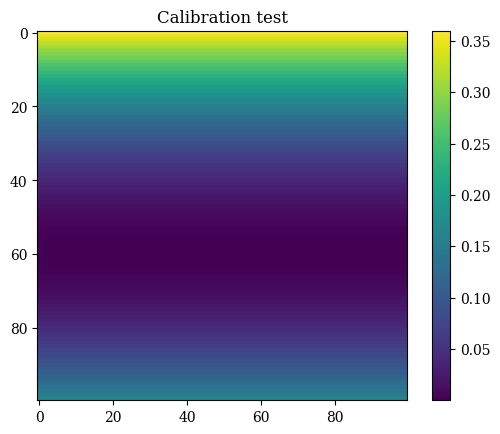

In [20]:
calibrate()

Performing the proper transformation to yield the correct representation for images, we can see the results below:

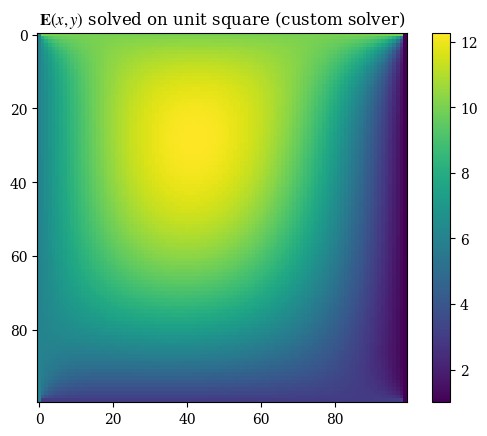

In [21]:
plt.imshow(correct_axes(E), interpolation="none")
plt.title(r"$\mathbf{E}(x, y)$ solved on unit square (custom solver)")
plt.colorbar()
plt.grid(False)
plt.show()

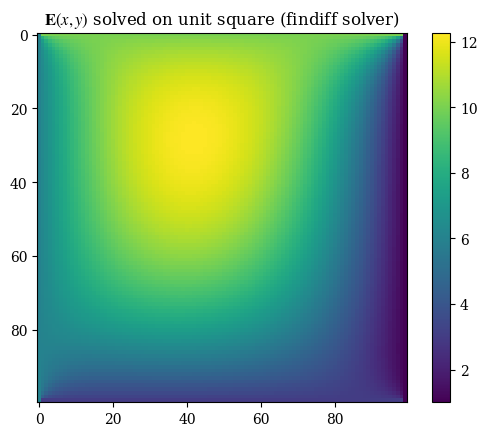

In [22]:
plt.imshow(correct_axes(E_findiff), interpolation="none")
plt.title(r"$\mathbf{E}(x, y)$ solved on unit square (findiff solver)")
plt.colorbar()
plt.grid(False)
plt.show()

In [23]:
imgX, imgY = np.meshgrid(np.arange(squaren), np.arange(squaren))

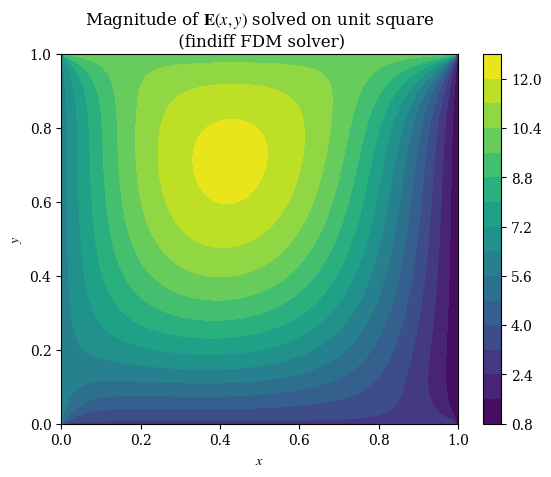

In [24]:
#plt.imshow(correct_axes(E_findiff), interpolation="none")
plt.contourf(X, Y, E_findiff, levels=15)
plt.title(r"Magnitude of $\mathbf{E}(x, y)$ solved on unit square" + "\n (findiff FDM solver)")
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.colorbar()
plt.grid(False)
plt.show()
#plt.savefig("fdm-validation.eps", dpi=300)

In [25]:
abs_difference = np.abs(E - E_findiff)

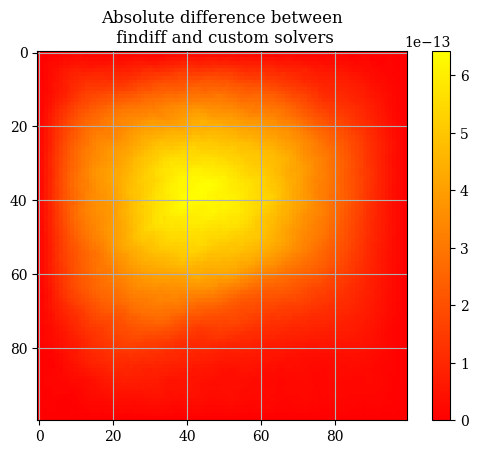

In [26]:
plt.imshow(correct_axes(abs_difference), interpolation="none", cmap="autumn")
plt.title("Absolute difference between\n findiff and custom solvers")
plt.colorbar()
plt.show()

In [27]:
abs_difference.max()

np.float64(6.430411758628907e-13)

The general differences between the findiff solver and the custom solver are very very miniscule on the order of $\mathcal{E} \sim 10 \times e^{-13}$. Therefore we will use the two solutions interchangeably and consider them equivalent. If we inspect the solution, we can clearly see that the boundaries follow the boundary conditions:

In [28]:
E[0, :] # E(0, y) = 6

array([6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6.,
       6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6.,
       6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6.,
       6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6.,
       6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6.,
       6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6.])

In [29]:
E[-1,:] # E(1, y) = 1

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

We can also verify with a 3D plot (where we now don't need to do the transpose trick because we're displaying 3D points and matplotlib is smart enough to figure that out):

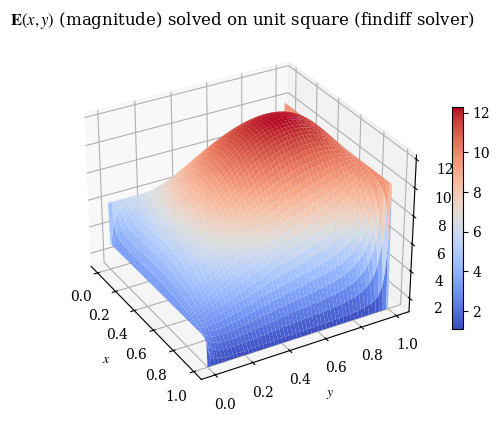

In [30]:
plot_E(E_findiff, label=r"$\mathbf{E}(x, y)$ (magnitude) solved on unit square (findiff solver)", rot=-30)

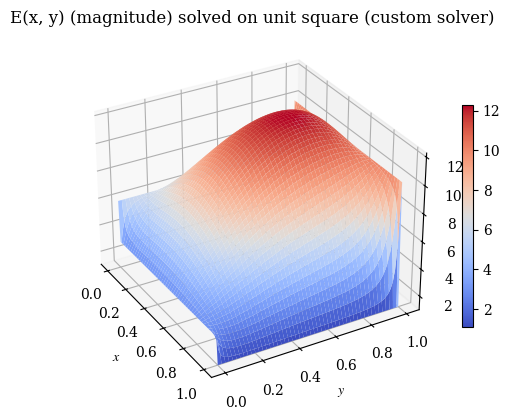

In [31]:
plot_E(E, label="E(x, y) (magnitude) solved on unit square (custom solver)", rot=-30)

The second test is the vector-valued version that uses the same coordinate transformations as the full version. However, do note that the Helmholtz equation's vector components are **independent** of each other, meaning that the components can just as well be simulated separately (as two scalar PDEs) as together (as one vector PDE).

In [34]:
def gen():
    step = randint(0, squaren)
    step2 = randint(0, squaren)
    print(f"Generated test point ({step*dx:.3f}, {step2*dx:.3f}) corresponding to index [{step}, {step2}]")

gen()

Generated test point (0.980, 0.420) corresponding to index [98, 42]


We test the validation points on the domain to compare against the FreeFEM version - note that this is because the finite element output is not on a regular mesh so cannot be compared value-by-value against the finite-difference result:

In [35]:
# convert real-space (x, y)
# coordinates to index (m, n)
# of the solution array
def convert_coord_index(x, y):
    x_idx = round(x*squaren)
    y_idx = round(y*squaren)
    # prevent out of bound
    # access errors
    if x_idx == squaren:
        x_idx = -1
    if y_idx == squaren:
        y_idx = -1
    return (x_idx, y_idx)

In [36]:
# unlike the freefem version, for this one
# we use the *index* locations of each point
# e.g. (1.0, 1.0) is equal to index [-1, -1]
# because it is the endpoint on both x and y
#
# for the ones where this method is a bit wonky, the
# convert_coord_index function is used
# which rounds the evaluation location to
# the closest set of [idx, idx] values
cases = [
    # boundary points
    (0, 0.5),
    (0.5, 0),
    (1., 0.5),
    (0.5, 1),
    # center points
    (0.25, 0.25),
    (0.5, 0.5),
    (0.75, 0.75),
    # the three nonstandard points
    # given by the gen() function above
    (0.6, 0.),
    (0.55, 0.562),
    (0.663, 0.413)
]

In [37]:
testpoints = [convert_coord_index(*c) for c in cases]

In [38]:
def validate():
    results = [0 for i in range(len(testpoints))]
    for p_idx, p in enumerate(testpoints):
        i = p[0]
        j = p[1]
        # uncomment to show the corresponding index
        # print("Index:", f"({i}, {j})")
        if i == 0:
            x = 0
        else:
            x = i/squaren if i!= -1 else 1
        if j == 0:
            y = 0
        else:
            y = j/squaren if j!= -1 else 1
        res = E[i][j]
        print(f"On test point ({x:.3f}, {y:.3f}), result value {res}")
        results[p_idx] = res
    return results

In [39]:
res = validate()

On test point (0.000, 0.500), result value 6.0
On test point (0.500, 0.000), result value 3.0
On test point (1.000, 0.500), result value 1.0
On test point (0.500, 1.000), result value 10.0
On test point (0.250, 0.250), result value 8.06733660036659
On test point (0.500, 0.500), result value 11.143921337204521
On test point (0.750, 0.750), result value 8.816212248786162
On test point (0.600, 0.000), result value 3.0
On test point (0.550, 0.560), result value 11.175781231851033
On test point (0.660, 0.410), result value 8.548252807003232


In [40]:
# from wave-parabolic-6-validation_4.edp
fem_results = [
    6.0,
    3.0,
    1.0,
    10.0,
    8.14275,
    11.3661,
    9.07413,
    3.0,
    11.4339,
    8.78092
]

In [41]:
res_array = np.array(res)
fem_res_array = np.array(fem_results)

In [42]:
bar_x = np.arange(10)

In [43]:
points_labels = [str(p) for p in testpoints]

In [44]:
def plot_barchart(width=0.25, save=False):
    fig, ax = plt.subplots(layout='constrained')
    ax.set_title("Comparison of numerical solutions")
    ax.set_xlabel("Test case")
    ax.set_ylabel("Numerical solution value")
    p1 = ax.bar(bar_x, res_array, width=width, label="FDM solution")
    #ax.bar_label(p1, label_type="edge", fmt=lambda x: '{x:.2f}')
    p2 = ax.bar(bar_x + 0.25, fem_res_array, width=width, label="FreeFEM solution")
    #ax.bar_label(p2, label_type="edge", fmt=lambda x: '{x:.2f}')
    p3 = ax.bar(bar_x + 0.5, np.abs(fem_res_array - res_array), width=width, label="Absolute difference\n(if nonzero)")
    #ax.bar_label(p2, label_type="edge", fmt=lambda x: '{x:.2f}')
    ax.set_xticks(bar_x, points_labels)
    ax.legend()
    plt.grid(False)
    if save:
        plt.savefig("validation-bar-chart.eps", dpi=600)
    else:
        plt.show()

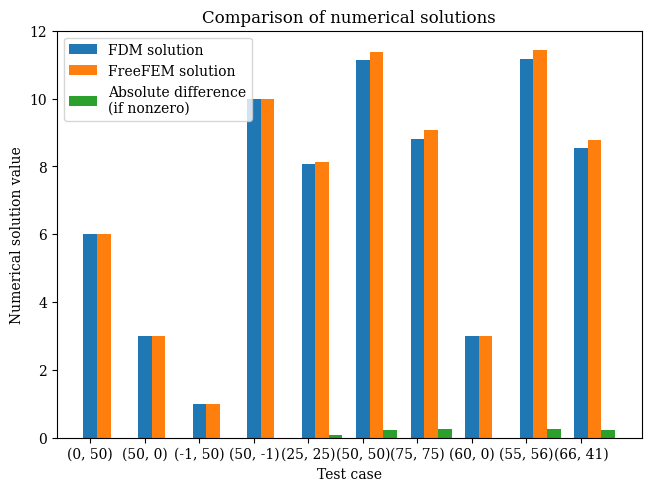

In [45]:
plot_barchart()

## Vector-valued validation test

We also want to do a simulation with the same boundary conditions but using a transformed coordinates system and vector-valued. As findiff can only solve scalar PDEs, in practice this means that we are solving 2 separate PDEs with different boundary conditions, and then combining them to get a vector-valued function. We are still using the same value of $k$ and the same domain (of a unit square) as before. For the vector PDE, the coordinates in $(x, y)$ space are:

$$
\begin{align}
E_x(x, 0) = 2, E_x(x, 1) = 7, E_x(0, y) = 0.5, E_x(1, y) = \pi \\
E_y(x, 0) = 2\pi, E_y(x, 1) = 3, E_y(0, y) = 12, E_y(1, y) = 1
\end{align}
$$

What we want is to convert to $(u, v)$ coordinates where $u = e^x$ and $v = e^y$. To preserve the same physical results, we must ensure that $E(u, v) = E(x, y)$. which means re-expressing each of those boundary conditions in terms of functions $E_u(u, v)$ and $E_v(u, v)$. To do this we use the forward transforms $E(u, v)  = E(e^x, e^y)$. This means the function stays identical, and is simply expressed in different coordinates.

As an example, consider the first boundary condition $E_x(x, 0) = 2$. The constant-valued outputs of the functions remains the same under the coordinate transformation, and the only thing that changes are the coordinates. That is to say, $E_u(u, v) = E_x(u(x),v(y)$. For this, we substitute $u(x)$ and $v(y)$ into $E_x(x, 0)$ as follows:

$$
E_u(u, v) =E_x(u(x), v(y))\big|_{(x, y) = (x, 0)} = E_x(u(x), v(0)) = E_x(e^x, 1) = E_u(u, 1)
$$

Doing so for each of the expressions, we obtain:

$$
E_u(u, 1) = 2, E_u(u, e) = 7, E_u(1, v) = 0.5, E_u(e, v) = \pi \\
E_v(u, 1) = 2\pi, E_v(u, e) = 3, E_v(1, v) = 12, E_v(e, v) = 1
$$

Where the domain $(x, y) \in [0, 1] \times [0, 1]$ becomes rescaled to $(u, v) \in [1, e] \times [1, e]$, as can be seen below:

In [47]:
u_example = np.exp(x)
print(f"New range: {u_example[0]:.3f}...{u_example[-1]:.3f}")

New range: 1.000...2.718


As a demonstration of the equivalence of solutions after a coordinate transform, consider the following change of variables $x \to u = 3x + 5$ on a given function:

In [48]:
def test_coord_transform():
    # not from zero because we don't want 1/0
    x = np.linspace(0.01, 2*np.pi, 50)
    # u = u(x) the forwards transform
    u_of_x = lambda x: 3*x + 5 # u in terms of x
    # x = x(u) the backwards transform
    x_of_u = lambda u: (u - 5)/3 # x in terms of u
    fig = plt.figure()
    fig.suptitle("A demonstration of coordinate transforms")
    ax1 = fig.add_subplot(3, 1, 1)
    ax1.set_title("$f(x)$ in $(x, y)$ coordinates")
    f = lambda x: np.sin(x)
    # plot in x-space
    ax1.plot(x, f(x))
    # plot in u-space
    ax2 = fig.add_subplot(3, 1, 2)
    ax2.set_title("$g(u)$ in $(u, v)$ coordinates")
    u = u_of_x(x)
    g = lambda u: np.sin(u)
    ax2.plot(u, g(u), linestyle="--")
    ax3 = fig.add_subplot(3, 1, 3)
    ax3.set_title("$f(x)$ reconstructed from $g(u)$")
    ax3.plot(x, g(x_of_u(u)))
    plt.subplots_adjust(hspace=0.75)
    plt.show()

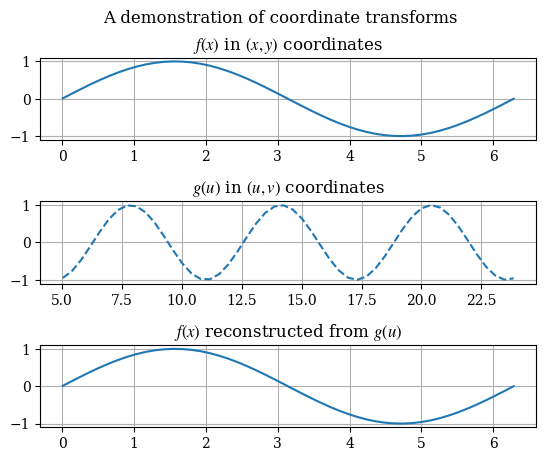

In [49]:
test_coord_transform()

To solve the PDE in the new coordinates, the PDE itself must be converted to the new coordinates. By the chain rule, it can be shown that the new form the vector-valued PDE takes is given by:

$$
\begin{align}
\left(u \frac{\partial}{\partial u} \left(u \frac{\partial}{\partial u}\right)
+ v \frac{\partial}{\partial v} \left(v \frac{\partial}{\partial v}\right)
+ k^2 \right) \tilde E_u(u, v) &= 0 \\
\left(u \frac{\partial}{\partial u} \left(u \frac{\partial}{\partial u}\right)
+ v \frac{\partial}{\partial v} \left(v \frac{\partial}{\partial v}\right)
+ k^2 \right) \tilde E_v(u, v) &= 0
\end{align}
$$

Note that in the numerical programming we must expand out the partial derivatives. The expanded version of the Helmholtz operator is:

$$
u \left(\frac{\partial}{\partial u} + u \frac{\partial^2}{\partial u^2}\right) + u \left(\frac{\partial}{\partial u} + u \frac{\partial^2}{\partial u^2}\right) + k^2
$$

In addition, we will convert the boundary conditions respectively to:

$$
\begin{align}
\tilde E_u(u, 1) = 2, \tilde E_u(u, e) = 7, \tilde E_u(1, v) = 0.5, \tilde E_u(e, v) = \pi \\
\tilde E_v(u, 1) = 2\pi, \tilde E_v(u, e) = 3, \tilde E_v(1, v) = 12, \tilde E_v(e, v) = 1
\end{align}
$$

In [50]:
# forward transformations
u_of_x = lambda x: np.exp(x)
v_of_y = lambda y: np.exp(y)

In [51]:
U = u_of_x(X)
V = v_of_y(Y)

We can see that the domain $[0, 1] \times [0, 1]$ in $(x, y)$ maps to $[1, e] \times [1, e]$ in $(u, v)$ coordinates:

In [52]:
U.min(), U.max()

(np.float64(1.0), np.float64(2.718281828459045))

Consider the first boundary condition $E_x(x, 0) = 2$. We can show that it takes the form $E_u(u, 1) = 2$ below:

In [53]:
example_Ex_func = lambda x, y: 2

In [54]:
example_Eu_func = example_Ex_func(u_of_x(x), v_of_y(y))

In [55]:
example_Eu_func

2

In [56]:
# again incapsulate in function to prevent variable
# overwrite in global scope
# if refactoring is best to make a class for everything
def solve_transformed_helmholtz(x=x, y=y, k=k, shape=shape):
    u = u_of_x(x)
    v = v_of_y(y)
    du = u[1] - u[0]
    dv = v[1] - v[0]
    # not sure if we need to convert to meshgrid for this
    U, V = np.meshgrid(u, v, indexing='ij')
    d_du = FinDiff(0, du)
    d_ddu = FinDiff(0, du, 2)
    d_dv = FinDiff(1, dv)
    d_ddv = FinDiff(1, dv, 2)
    # helmholtz operator
    # Helmholtz = Coef(U)*d_du + Coef(U**2)*d_ddu + Coef(V)*d_dv + Coef(V**2)*d_ddv + Coef(k**2)*Id()
    Helmholtz = Coef(U)*(d_du + Coef(U)*d_ddu) + Coef(V)*(d_dv + Coef(V)*d_ddv) + Coef(k**2)*Id()
    rhs = np.zeros(shape)
    # we need separate boundary conditions for E_u and E_v components
    # of the vector-valued PDE
    bc_u = BoundaryConditions(shape)
    bc_v = BoundaryConditions(shape)
    # here note that we set based on the boundaries
    # by index not by value
    # the domain is [1, e] x [1, e]
    bc_u[:, 0] = 2.0 # E_u(u, 1)
    bc_u[:, -1] = 7.0 # E_u(u, e)
    bc_u[0, :] = 0.5 # etc.
    bc_u[-1, :] = np.pi
    
    bc_v[:, 0] = 2*np.pi
    bc_v[:, -1] = 3
    bc_v[0, :] = 12
    bc_v[-1, :] = 1
    
    # PDE for u component of electric field
    # the Helmholtz operator is identical for both PDEs
    pde_u = PDE(Helmholtz, rhs, bc_u)
    pde_v = PDE(Helmholtz, rhs, bc_v)
    solution_u = pde_u.solve()
    solution_v = pde_v.solve()
    return solution_u, solution_v

In [57]:
transform_u, transform_v = solve_transformed_helmholtz()

After solving for the components of $\mathbf{E}$, we can visualize $\mathbf{E}$ as a vector field as follows:

In [58]:
def magnitude(E1, E2):
    squared_norm = E1**2 + E2**2
    return np.sqrt(squared_norm)

In [59]:
def plotE_uvspace(u=U, v=V, Usol=transform_u, Vsol=transform_v, desc=None, opacity=0.5):
    vec_density = 6 # plot one vector for every 10 points
    contour_levels = 12 # number of contours (filled isocurves) to plot
    transform_mag = magnitude(transform_u, transform_v)
    levels = np.linspace(transform_mag.min(), transform_mag.max(), contour_levels)
    # plot the filled isocurves
    plt.contourf(u, v, transform_mag, levels=levels)
    plt.colorbar()
    # plot the vectors
    plt.quiver(u[::vec_density, ::vec_density], v[::vec_density, ::vec_density], Usol[::vec_density, ::vec_density], Vsol[::vec_density, ::vec_density], scale=400, headwidth=2, color=(1, 1, 1, opacity))
    plt.xlabel("$u$")
    plt.ylabel("$v$")
    if not desc:
        plt.title(r"$\mathbf{E}(u, v)$ solved on unit square in $(u, v)$ coordinates")
    else:
        plt.title(desc)
    plt.show()

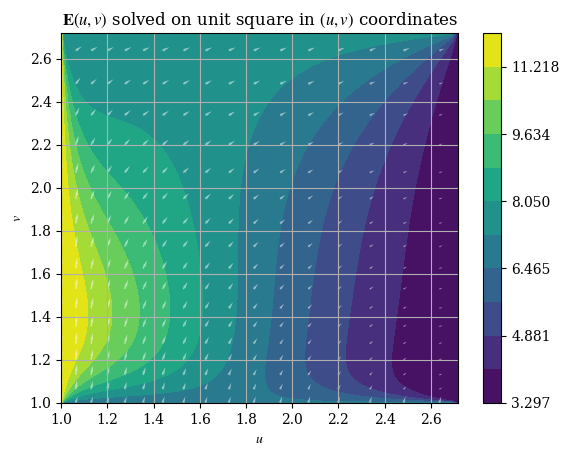

In [60]:
plotE_uvspace()

And the magnitude is respectively given by $E = \|\mathbf{E}\| = \|E_u \hat{\mathbf{u}} + E_v \hat{\mathbf{v}}\| = \sqrt{E_u{}^2 + E_v{}^2}$, which can be plotted as shown:

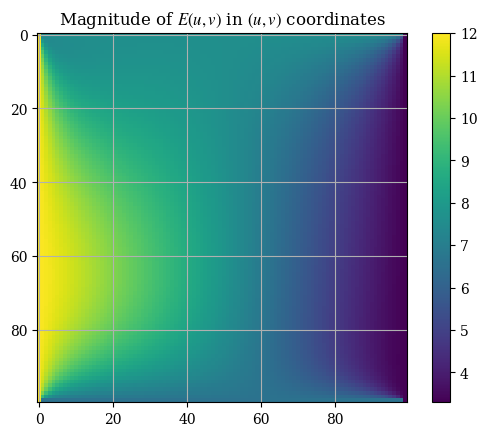

In [61]:
plt.imshow(correct_axes(magnitude(transform_u, transform_v)), interpolation="none")
plt.title("Magnitude of $E(u, v)$ in $(u, v)$ coordinates")
plt.colorbar()
plt.show()

Note that the axes tickmarks can be ignored (they are not accurate) , as `imshow()` treats the input as if it were an image (which it obviously is not). We can validate the solution with the analytical expressions for the magnitude calculated from the boundary conditions for $E_u$ and $E_v$:

In [62]:
E_prime_bottom = magnitude(2, 2*np.pi)
E_prime_top = magnitude(7, 3)
E_prime_left = magnitude(0.5, 12)
E_prime_right = magnitude(np.pi, 1)
print(f"Analytical values - top: {E_prime_top:.3f}, right: {E_prime_right:.3f}, bottom: {E_prime_bottom:.3f}, left: {E_prime_left:.3f}")

Analytical values - top: 7.616, right: 3.297, bottom: 6.594, left: 12.010


Which agree reasonably with the values shown in the plot. We will now do the comparison with the finite element solution for the validation.

In [63]:
# convert transformed-space (u, v)
# coordinates to index (m, n)
# of the solution array
def convert_coord_index_uv(u, v):
    u_idx = round((u-1)/(np.e-1)*squaren)
    v_idx = round((v-1)/(np.e-1)*squaren)
    # prevent out of bound
    # access errors
    if u_idx == squaren:
        u_idx = -1
    if v_idx == squaren:
        v_idx = -1
    return (u_idx, v_idx)

In [64]:
def validate_vector_uv():
    # here (u, v) is the domain [1, e] x [1, e]
    points = [
        [np.e/2, 1], # bottom
        [1, np.e/2], # left
        # the remainder are random points
        [1.3, 2.2],
        [1.7, 1.65],
        [2.4, 2.5]
    ]
    
    for p in points:
        idx_u, idx_v = convert_coord_index_uv(*p)
        transform_mag = magnitude(transform_u, transform_v)
        res = transform_mag[idx_u, idx_v]
        print(f"On test point ({p[0]:.3f}, {p[1]:.3f}), magnitude {res:.4f}")

In [65]:
validate_vector_uv()

On test point (1.359, 1.000), magnitude 6.5938
On test point (1.000, 1.359), magnitude 12.0104
On test point (1.300, 2.200), magnitude 9.0540
On test point (1.700, 1.650), magnitude 8.5958
On test point (2.400, 2.500), magnitude 6.3063


To evaluate the solution $(x, y)$ coordinates, we remap each of the points from $(u, v)$ space to $(x, y)$ space, that is, applying the inverse transforms $x(u) = \ln u$ and $y(v) = \ln v$ (again the prime here denotes transformation, it is not a derivative symbol. As the solution is numerical (and therefore discrete), we must interpolate it to find $\tilde{\mathbf{E}}(u, v)$ so that we can calculate the correct values according to the formula $\mathbf{E}(x, y) = \tilde{\mathbf{E}}(x(u), y(v))$. For this we use `scipy.optimize.curve_fit` with a cubic polynomial in the form $f(x, y) = ax^3 + by^3 + cx^2 y^2 + dx^2 + gy^2 + hxy + mx + nx + r$ on both components of $\mathbf{E}'$:

$$
\begin{align}
E_u(u, 1) = 2, E_u(u, e) = 7, E_u(1, v) = 0.5, E_u(e, v) = \pi \\
E_v(u, 1) = 2\pi, E_v(u, e) = 3, E_v(1, v) = 12, E_v(e, v) = 1
\end{align}
$$

In [66]:
# have to flatten arrays to make this work
def interpolation_func(X, a=1, b=1, c=1, d=1, g=1, h=1, m=1, n=1, r=1):
    u_raw, v_raw = X
    squaren = n # change based on the value of squaren globally
    x = u_raw
    y = v_raw
    out = a*x**3 + b*y**3 + c*x**2*y**2 + d*x**2 + g*y**2 + h*x*y + m*x + n*x + r
    return out.flatten()

In [67]:
sol_u, cov_u = optimize.curve_fit(interpolation_func, (U.flatten(), V.flatten()), transform_u.flatten())

In [68]:
sol_v, cov_v = optimize.curve_fit(interpolation_func, (U.flatten(), V.flatten()), transform_v.flatten())

We can then use the interpolated function as usual functions, `E_u(u, v)` and `E_v(u, v)` that can be given arguments, which represents $\mathbf{E}'(u, v)$:

In [69]:
# these take in vector-valued inputs i.e. you need to use np.meshgrid for them
E_u = lambda u, v: interpolation_func((u.flatten(), v.flatten()), *sol_u).reshape(squaren, squaren)
E_v = lambda u, v: interpolation_func((u.flatten(), v.flatten()), *sol_v).reshape(squaren, squaren)
Emag_uv = lambda u, v: magnitude(E_u(u, v), E_v(u, v))

And we can plot it just like the original numerical solution:

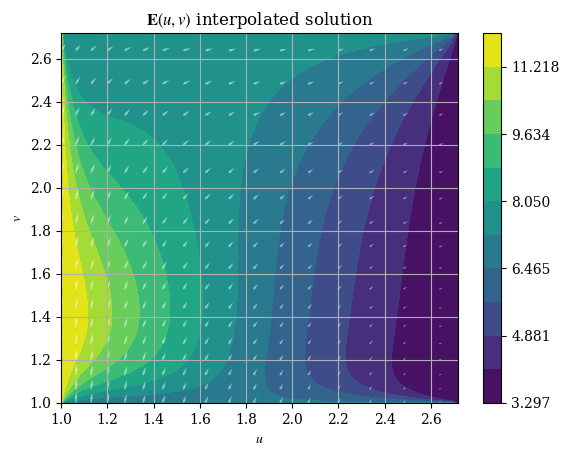

In [70]:
plotE_uvspace(Usol=E_u(U, V), Vsol=E_v(U, V), desc=r"$\mathbf{E}(u, v)$ interpolated solution")

<>:2: SyntaxWarning: invalid escape sequence '\m'
<>:2: SyntaxWarning: invalid escape sequence '\m'
C:\Users\Jacky\AppData\Local\Temp\ipykernel_92892\1675798493.py:2: SyntaxWarning: invalid escape sequence '\m'
  plt.title("Magnitude of interpolated $\mathbf{E}(u, v)$ in $(u, v)$ coordinates")


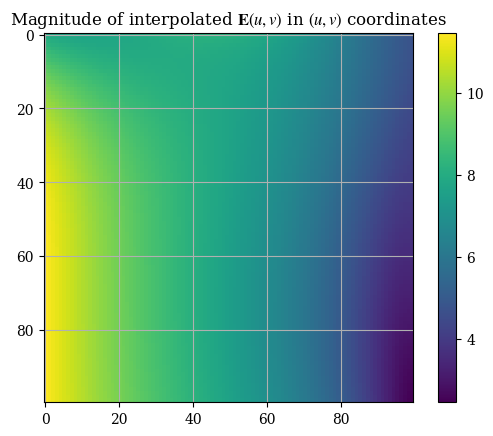

In [71]:
plt.imshow(correct_axes(Emag_uv(U, V)), interpolation="none")
plt.title("Magnitude of interpolated $\mathbf{E}(u, v)$ in $(u, v)$ coordinates")
plt.colorbar()
plt.show()

We can compare the interpolation functions' accuracy with the original numerical solution:

In [72]:
interpolation_err_u = np.abs(E_u(U, V) - transform_u)
interpolation_err_v = np.abs(E_v(U, V) - transform_v)

For instance, we can find difference of the interpolation as compared to the numerical solution:

In [77]:
interpolation_err = magnitude(interpolation_err_u, interpolation_err_v)

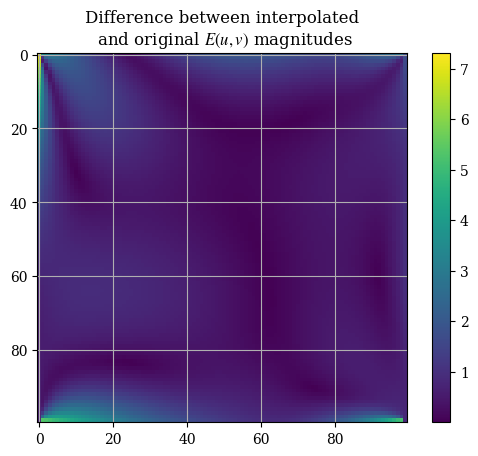

In [79]:
plt.imshow(correct_axes(interpolation_err), interpolation="none")
plt.title("Difference between interpolated\n and original $E(u, v)$ magnitudes")
plt.colorbar()
plt.show()

We can see that the interpolation is quite good _except_ for the boundaries. This can be seen from the median and mean of the interpolation error, which is (relatively) small:

In [82]:
np.median(interpolation_err)

np.float64(0.4978049155751837)

In [86]:
np.mean(interpolation_err)

np.float64(0.6408549856200115)

We can also evaluate the numerial vs interpolated solution next to each other on a common set of points:

In [87]:
# we use pointwise variants of the interpolation function as opposed
# to the one that takes vectorized input
E_u_pointwise = lambda u, v: interpolation_func((u, v), *sol_u)
E_v_pointwise = lambda u, v: interpolation_func((u, v), *sol_v)
E_uv_pointwise = lambda u, v: float(np.sqrt(E_u_pointwise(u, v)**2 + E_v_pointwise(u, v)**2))

In [88]:
def validate_interpolate_vs_num_uv():
    # here (u, v) is the domain [1, e] x [1, e]
    points = [
        [(np.e-1)/2, 1], # bottom
        [1, (np.e-1)/2], # left
        # the remainder are random points
        [1.3, 2.2],
        [1.7, 1.65],
        [2.4, 2.5]
    ]
    
    print("Comparison of magnitudes (numerical vs interpolated)")
    for p in points:
        idx_u, idx_v = convert_coord_index_uv(*p)
        transform_mag = magnitude(transform_u, transform_v)
        res = transform_mag[idx_u, idx_v]
        interp_res = E_uv_pointwise(*p)
        print(f"On test point ({p[0]:.3f}, {p[1]:.3f}), numerical solution {res:.4f}, interpolated solution {float(interp_res):.4f}")

In [89]:
validate_interpolate_vs_num_uv()

Comparison of magnitudes (numerical vs interpolated)
On test point (0.859, 1.000), numerical solution 6.5938, interpolated solution 13.2166
On test point (1.000, 0.859), numerical solution 12.0104, interpolated solution 11.5047
On test point (1.300, 2.200), numerical solution 9.0540, interpolated solution 8.5078
On test point (1.700, 1.650), numerical solution 8.5958, interpolated solution 7.4088
On test point (2.400, 2.500), numerical solution 6.3063, interpolated solution 5.6210


C:\Users\Jacky\AppData\Local\Temp\ipykernel_92892\1914026686.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  E_uv_pointwise = lambda u, v: float(np.sqrt(E_u_pointwise(u, v)**2 + E_v_pointwise(u, v)**2))


We can also check for the boundary conditions against their analytical values:

In [90]:
print(f"Analytical values - top: {E_prime_top:.3f}, right: {E_prime_right:.3f}, bottom: {E_prime_bottom:.3f}, left: {E_prime_left:.3f}")

Analytical values - top: 7.616, right: 3.297, bottom: 6.594, left: 12.010


In [91]:
half_u = (np.e - 1)/2
half_v = (np.e - 1)/2
E_interp_uv_top = E_uv_pointwise(half_u, np.e)
E_interp_uv_right = E_uv_pointwise(np.e, half_v)
E_interp_uv_bottom = E_uv_pointwise(half_u, 1)
E_interp_uv_left = E_uv_pointwise(1, half_v)

C:\Users\Jacky\AppData\Local\Temp\ipykernel_92892\1914026686.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  E_uv_pointwise = lambda u, v: float(np.sqrt(E_u_pointwise(u, v)**2 + E_v_pointwise(u, v)**2))


In [92]:
print(f"Interpolated values - top: {E_interp_uv_top:.3f}, right: {E_interp_uv_right:.3f}, bottom: {E_interp_uv_bottom:.3f}, left: {E_interp_uv_left:.3f}")

Interpolated values - top: 8.898, right: 2.265, bottom: 13.217, left: 11.505


Thus, we see that our interpolation is primarily poor at the boundaries (most significantly, the bottom boundary), even though it is not bad at the center of the domain. To examine the issue further, we can plot the boundaries obtained from the original numerical solution as well as the transformation, which is shown below:

In [95]:
def compare_uv_bcs(Emag_numerical = magnitude(transform_u, transform_v), Emag_interp = Emag_uv(U, V), u=u_of_x(x), v=v_of_y(y), desc=None):
    fig = plt.figure(layout='constrained')
    if not desc:
        fig.suptitle("Comparison of numerical and interpolation\n solutions evaluted on boundaries")
    else:
        fig.suptitle(desc)
    spec = fig.add_gridspec(ncols=2, nrows=2)
    ax1 = fig.add_subplot(spec[0, 0])
    ax1.set_title("Top boundary")
    # we use [1:-2] because we don't want the endpoints which are connected
    # to the nodes of other boundaries
    ax1.plot(u[1:-2], Emag_numerical[:, -1][1:-2], label="numerical")
    ax1.plot(u, Emag_interp[:, -1], label="interpolated")
    ax1.legend()
    ax2 = fig.add_subplot(spec[0, 1])
    ax2.set_title("Bottom boundary")
    ax2.plot(u[1:-2], Emag_numerical[:, 0][1:-2], label="numerical")
    ax2.plot(u, Emag_interp[:, 0], label="interpolated")
    ax2.legend()
    ax3 = fig.add_subplot(spec[1, 0])
    ax3.set_title("Left boundary")
    ax3.plot(v[1:-2], Emag_numerical[:, 0][1:-2], label="numerical")
    ax3.plot(v, Emag_interp[:, 0], label="interpolated")
    ax3.legend()
    ax4 = fig.add_subplot(spec[1, 1])
    ax4.set_title("Right boundary")
    ax4.plot(v[1:-2], Emag_numerical[:, -1][1:-2], label="numerical")
    ax4.plot(v, Emag_interp[:, -1], label="interpolated")
    ax4.legend()
    plt.show()

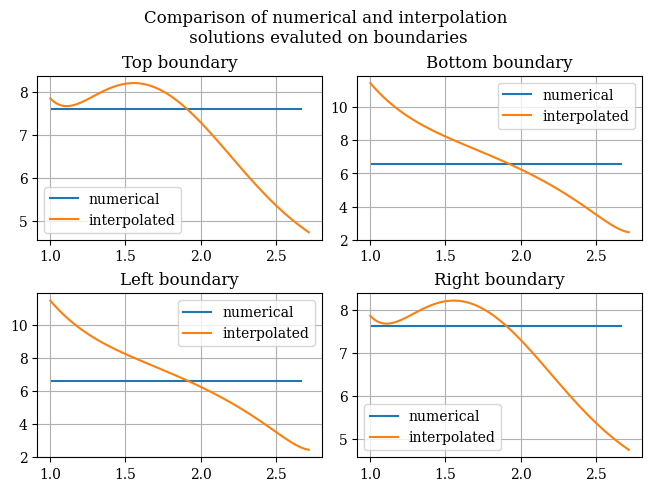

In [94]:
compare_uv_bcs()

This confirms our theory that the boundaries are where the issues lie. This means we need to do more testing to find a fitting method that respects the boundary conditions.

But this is not enough. We then need to apply the backwards transforms, which, like the forward transforms, preserves the features of the function, including having constant boundary conditions just like the original boundary conditions.

Finally, we evaluate the original function $\mathbf{E}(x, y)$ through the interpolated version of $\mathbf{E}'(u, v)$, via $\mathbf{E}(x, y) = \mathbf{E}'(x(u), y(v))$. We have $x(u) = \ln u, y(v) = \ln v$. Evaluating these on the arrays of $u$ and $v$ recovers $\mathbf{E}(x, y)$.

In [101]:
# backwards transforms
x_of_u = lambda u: np.log(u)
y_of_v = lambda v: np.log(v)

E_x = E_u(x_of_u(U), y_of_v(V))
E_y = E_v(x_of_u(U), y_of_v(V))

In [102]:
def plotE_xyspace(x=X, y=Y, E_x=E_x, E_y=E_y, desc=None, opacity=0.5):
    vec_density = 6 # plot one vector for every 10 points
    contour_levels = 12 # number of contours (filled isocurves) to plot
    E_mag = magnitude(E_x, E_y)
    levels = np.linspace(E_mag.min(), E_mag.max(), contour_levels)
    # plot the filled isocurves
    plt.contourf(x, y, E_mag, levels=levels)
    # plot the vectors
    plt.quiver(x[::vec_density, ::vec_density], y[::vec_density, ::vec_density], E_x[::vec_density, ::vec_density], E_y[::vec_density, ::vec_density], scale=400, headwidth=2, color=(1, 1, 1, opacity))
    plt.xlabel("$x$")
    plt.ylabel("$y$")
    if not desc:
        plt.title(r"$\mathbf{E}(u, v)$ transformed back to $(x, y)$ coordinates")
    else:
        plt.title(desc)
    plt.colorbar()
    plt.show()

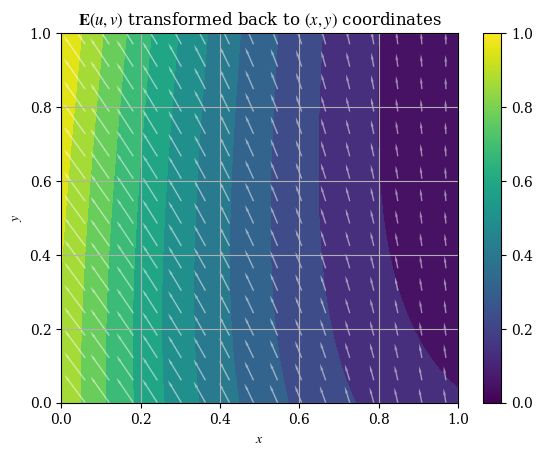

In [103]:
plotE_xyspace()

We may also plot the magnitude of our transformed solution:

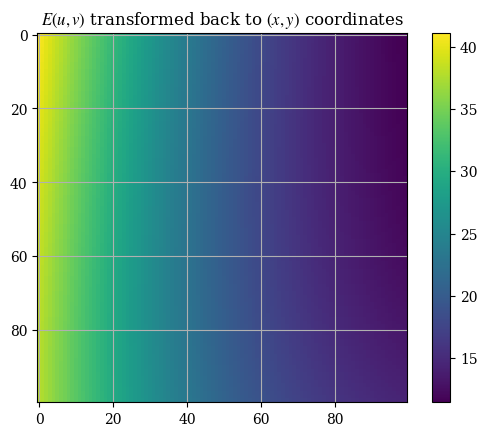

In [107]:
E_xy_mag = correct_axes(magnitude(E_x, E_y))
plt.title(r"$E(u, v)$ transformed back to $(x, y)$ coordinates")
plt.imshow(E_xy_mag)
plt.colorbar()
plt.show()